# Exercise 1
Det här är uppgift 1 där vi ställer upp modellen och försöker lösa den. 

In [33]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

## Data

In [34]:

# DATA
countries = ['DE', 'DK', 'SE']
techs = ['Wind', 'PV', 'Gas', 'Hydro']
efficiency = {'Wind': 1, 'PV': 1, 'Gas': 0.4, 'Hydro': 1}
discountrate = 0.05
hydro_max =33 * 10**6
last_hour = 8759
CO2_gas_emission_factor = 0.202

# READ CSV
input_data = pd.read_csv('data/TimeSeries.csv', index_col=[0])
cap_max_data = pd.read_csv('data/capMax.csv', index_col=[0])  # MWh
cost_data = pd.read_csv('data/costs.csv', index_col=[0])

print(f"Total demand DK: {input_data['Load_DK'].sum()/1000}")
print(f"Total demand DE: {input_data['Load_DE'].sum()/1000}")
print(f"Total demand SE: {input_data['Load_SE'].sum()/1000}")


Total demand DK: 43606.417933
Total demand DE: 637617.0658
Total demand SE: 177332.34219999998


## Utility functions

In [35]:
def annualize_cost(tech):
    lifetime = cost_data.loc[tech]["lifetime"]
    return discountrate/(1-1/(1+discountrate)**lifetime)

def capacity_max(model, n, g):
    capMax = {}
    if g in cap_max_data.columns:
        capMax[n, g] = float(cap_max_data[g].loc[cap_max_data.index == n])
        return 0.0, capMax[n, g]
    else:
        return 0.0, None

def demandData():
    demand = {}
    for n in model.nodes:
        for t in model.time:
            demand[n, t] = input_data.iloc[t][f"Load_{n}"]
    return demand

def get_load_factor(tech, time, node):
    """
    Checks performance of Wind and solar at the provided
    node and time
    """
    if tech != "Wind" and tech != "PV":
        return 1
    text = f"{tech}_{node}"
    value = input_data.iloc[time][text]
    if value <= 0.00001:
        return 0.00001 
    return value

def solve_model(model):
    opt = SolverFactory("gurobi_direct")
    opt.options["threads"] = 4
    print("========================= SOLVING MODEL =========================")
    return opt.solve(model, tee=True)

def calculate_capacities(model):
    capTot = {}
    for n in model.nodes:
        for g in model.gens:
            capTot[n, g] = round(model.capa[n, g].value/1e3) #GW
    return capTot

def calculate_co2_total(prodTot):
    return CO2_gas_emission_factor * (prodTot["DE","Gas"] + prodTot["DK","Gas"] + prodTot["SE","Gas"]) * 1000 / (model.efficiency["Gas"]) # MWh

## Plot functions

In [47]:


def plot_capacities(model,capTot):
    pprint.pprint(capTot)

    dk_cap = [model.capa["DK",tech].value for tech in model.gens]
    de_cap = [model.capa["DE",tech].value for tech in model.gens]
    se_cap = [model.capa["SE",tech].value for tech in model.gens]

    labels = [tech for tech in model.gens]
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dk_cap, width, label='DK')
    rects2 = ax.bar(x + width/2, de_cap, width, label='DE')
    rects3 = ax.bar(x + width*3/2, se_cap, width, label='SE')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Capacities')
    ax.set_title('Capacities by type and country')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

def plot_first_week(model):
    de_time = range(0,168)
    de_wind = np.array([ model.prod["DE", "Wind", t].value for t in de_time])
    de_pv = np.array([ model.prod["DE", "PV", t].value for t in de_time])
    de_gas = np.array([ model.prod["DE", "Gas", t].value for t in de_time])
    de_hydro = np.array([ model.prod["DE", "Hydro", t].value for t in de_time])
    de_total = de_wind + de_pv + de_gas + de_hydro

    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(12)

    ax1.set_ylim([0,100000])
    ax2.set_ylim([0,100000])

    ax1.plot(de_time, de_wind)
    ax1.plot(de_time, de_pv)
    ax1.plot(de_time, de_gas)
    ax1.plot(de_time, de_hydro)

    ax2.plot(de_time, de_total)

    plt.grid(axis='x', color='0.95')
    ax1.legend(["Wind", "PV", "Gas", "Hydro"], loc="lower left")
    ax1.set_title('By production type')
    ax2.set_title('Total')

    plt.show()

## Create model and sets

In [37]:
def create_model():
    model = ConcreteModel()
    model.nodes = Set(initialize=countries, doc='countries')
    model.time = Set(initialize=input_data.index, doc='hours')
    model.gens = Set(initialize=techs, doc="Technologies")
    return model

model = create_model()

## Set parameters

In [38]:
def set_model_parameters(model):
    model.demand = Param(model.nodes, model.time, initialize=demandData())
    model.efficiency = Param(
    model.gens, initialize=efficiency, doc='Conversion efficiency')
    return model

model = set_model_parameters(model)

## Create variables

In [39]:
def set_base_model_variables(model):
    model.prod = Var(model.nodes, model.gens, model.time,
                 domain=NonNegativeReals,
                 doc="Production")
    model.capa = Var(model.nodes, model.gens,
                    bounds=capacity_max, doc='Generator cap')
    model.water_level = Var(model.time, bounds=(0, hydro_max), doc="Water level of reservoir")
    return model

model = set_base_model_variables(model)

## Constraints

In [40]:
# Total supply at each hour must meet the demand.
def demand_rule(model, node, gen, time):
    return sum([ model.prod[node, tech, time] for tech in techs]) >= model.demand[node, time]

# Production must be smaller than capacity
def prod_rule(model, node, gen,time):
    return model.prod[node, gen, time] <= model.capa[node,gen] * get_load_factor(gen,time,node)

# Producing electricity from hydro must decrease water level
def hydro_rule(model,time):
    if (time > 0):
        return model.water_level[time] == model.water_level[time - 1] - model.prod["SE", "Hydro", time] + input_data.iloc[time]["Hydro_inflow"]
    else:
        return model.water_level[time] == model.water_level[last_hour] - model.prod["SE", "Hydro", time] + input_data.iloc[time]["Hydro_inflow"]

In [41]:
def set_base_model_constraints(model):
    # Total supply at each hour must meet the demand.
    model.demand_constraint = Constraint(model.nodes, model.gens,
                                        model.time, rule=demand_rule)

    # Production must be smaller than capacity                                     
    model.prod_constraint = Constraint(model.nodes, model.gens, model.time, rule=prod_rule)

    # Producing electricity from hydro must decrease water level
    model.hydro_constraint = Constraint(model.time, rule=hydro_rule)
    return model

model = set_base_model_constraints(model)

## Objective function

In [42]:
def investment_cost(model):
    return sum(model.capa[node, tech] * cost_data.loc[tech]["investment_cost"]  * annualize_cost(tech) for tech in model.gens for node in model.nodes)

def running_cost(model):
    return sum(model.prod[node, tech, t] * (cost_data.loc[tech]["variable_cost"] + cost_data.loc[tech]["fuel_cost"] / (model.efficiency[tech] * get_load_factor(tech,t,node))) for node in model.nodes for tech in model.gens for t in model.time)

def objective_rule(model):
    return running_cost(model) + investment_cost(model)

def set_objective_function(model):
    model.objective = Objective(
    rule=objective_rule, sense=minimize, doc='Objective function')
    return model

model = set_objective_function(model)

## Solve model

In [43]:
results = solve_model(model)
results.write()

========================= SOLVING MODEL =========================
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown_copy
  Lower bound: 37237890657.281975
  Upper bound: 37237890657.281975
  Number of objectives: 1
  Number of constraints: 219000
  Number of variables: 113892
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 113892
  Number of nonzeros: 657000
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 9.11
  Status: ok
  Wallclock time: 5.965169906616211
  Termination condition:

## Calculate production

In [44]:
def calculate_total_production(model):
    prodTot = {}
    for node in model.nodes:
        for tech in model.gens:
            for t in model.time:
                if not (node, tech) in prodTot:
                    prodTot[node, tech] = round(model.prod[node, tech, t].value /1e3) # GW
                else:
                    prodTot[node, tech] += round(model.prod[node,tech,t].value /1e3)
    return prodTot

def print_totals(model, prodTot):
    costTot = value(model.objective) / 1e6  # Million EUR
    pprint.pprint(prodTot)
    print(f"Total cost: {round(costTot)} million EUR")

    total_co2 = calculate_co2_total(prodTot)
    print(f"Total CO2 emission: {total_co2} tons CO2")

prodTot = calculate_total_production(model)
print_totals(model,prodTot)

{('DE', 'Gas'): 248032,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 88158,
 ('DE', 'Wind'): 301382,
 ('DK', 'Gas'): 16891,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 1213,
 ('DK', 'Wind'): 25174,
 ('SE', 'Gas'): 9874,
 ('SE', 'Hydro'): 64991,
 ('SE', 'PV'): 0,
 ('SE', 'Wind'): 102450}
Total cost: 37238 million EUR
Total CO2 emission: 138772485.0 tons CO2


## Plots

{('DE', 'Gas'): 92,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 92,
 ('DE', 'Wind'): 131,
 ('DK', 'Gas'): 7,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 2,
 ('DK', 'Wind'): 10,
 ('SE', 'Gas'): 16,
 ('SE', 'Hydro'): 14,
 ('SE', 'PV'): 0,
 ('SE', 'Wind'): 31}


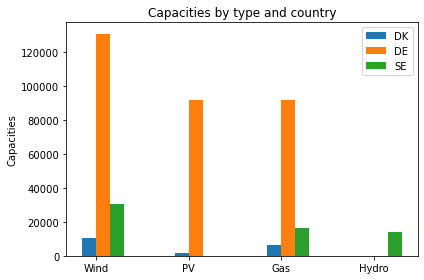

In [45]:
capTot = calculate_capacities(model)
plot_capacities(model,capTot)

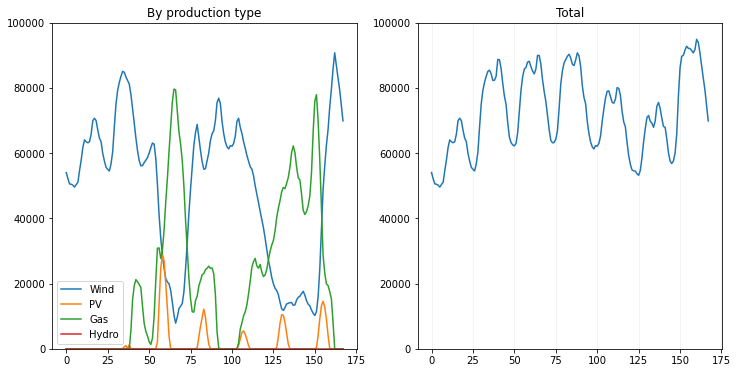

In [48]:
plot_first_week(model)
